In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



In [ ]:

# CIFAR-10 dataset with normalization and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

Files already downloaded and verified


In [ ]:

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 512 * 2 * 2),
            nn.ReLU(),
            nn.BatchNorm1d(512 * 2 * 2),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output 32x32 RGB images
        )

    def forward(self, z):
        return self.model(z)
# Critic (Discriminator)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1)  # Output is a scalar for WGAN
        )

    def forward(self, x):
        return self.model(x)





In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to device
NetG = Generator().to(device)
NetC = Critic().to(device)

In [ ]:

# Wasserstein Loss Function
def wasserstein_loss(y_real, y_fake):
    return torch.mean(y_fake) - torch.mean(y_real)

# Gradient Penalty function
def gradient_penalty(critic, real_data, fake_data):
    # Ensure tensors are on the same device
    alpha = torch.rand(real_data.size(0), 1, 1, 1).to(real_data.device)
    interpolates = alpha * real_data + (1 - alpha) * fake_data

    interpolates.requires_grad_(True)
    critic_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradient_norm = gradients.view(gradients.size(0), -1).norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1) ** 2)

    return penalty

In [ ]:
import torch
import torch.optim as optim

# Function to compute the gradient norm
def gradient_norm(model):
    norms = []
    for param in model.parameters():
        if param.grad is not None:
            norms.append(param.grad.norm().item())
    return norms

# Train the WGAN, capturing losses, gradient norms, and printing updates
def train_wgan(generator, critic, dataloader, num_epochs, device):
    optimizer_G = optim.RMSprop(generator.parameters(), lr=0.00005)
    optimizer_D = optim.RMSprop(critic.parameters(), lr=0.00005)

    # Lists to store generator and critic losses, and gradient norms
    generator_losses = []
    critic_losses = []
    gradient_norms_generator = []
    gradient_norms_critic = []

    for epoch in range(num_epochs):
        epoch_generator_loss = 0
        epoch_critic_loss = 0
        generator_norms = []
        critic_norms = []

        iterations = 0
        for i, (data, _) in enumerate(dataloader):
            optimizer_D.zero_grad()
            real_data = data.to(device)
            z = torch.randn(real_data.size(0), 100).to(device)
            fake_data = generator(z)

            # Critic update
            critic_loss = wasserstein_loss(critic(real_data), critic(fake_data)) + gradient_penalty(critic, real_data, fake_data)
            critic_loss.backward()
            critic_norms.append(gradient_norm(critic))  # Store gradient norms
            optimizer_D.step()

            epoch_critic_loss += critic_loss.item()
            iterations += 1

            # Generator update every 5 iterations
            if i % 5 == 0:
                optimizer_G.zero_grad()
                fake_data = generator(z)
                generator_loss = -torch.mean(critic(fake_data))
                generator_loss.backward()
                generator_norms.append(gradient_norm(generator))  # Store gradient norms
                optimizer_G.step()

                epoch_generator_loss += generator_loss.item()

        # Store the average losses and gradient norms
        generator_losses.append(epoch_generator_loss / (iterations / 5))
        critic_losses.append(epoch_critic_loss / iterations)
        gradient_norms_generator.append(generator_norms)
        gradient_norms_critic.append(critic_norms)

        # Print epoch progress
        print(f'Epoch {epoch+1}/{num_epochs}, Generator Loss: {generator_losses[-1]:.4f}, Critic Loss: {critic_losses[-1]:.4f}')

    return generator_losses, critic_losses, gradient_norms_critic, gradient_norms_generator


In [ ]:
generator_losses, critic_losses, gradient_norms_critic, gradient_norms_generator = train_wgan(NetG, NetC, trainloader, num_epochs=20,device = device)

Epoch 1/20, Generator Loss: 600.5743, Critic Loss: -1159.7799
Epoch 2/20, Generator Loss: 705.6197, Critic Loss: -756.0121
Epoch 3/20, Generator Loss: 792.0210, Critic Loss: -1263.8970
Epoch 4/20, Generator Loss: 253.6710, Critic Loss: 14667.0407
Epoch 5/20, Generator Loss: 70.6522, Critic Loss: 216.3523
Epoch 6/20, Generator Loss: 299.9773, Critic Loss: -729.2561
Epoch 7/20, Generator Loss: 410.4903, Critic Loss: -1259.0691
Epoch 8/20, Generator Loss: 493.2754, Critic Loss: -643.7030
Epoch 9/20, Generator Loss: 1083.0696, Critic Loss: -1988.2585
Epoch 10/20, Generator Loss: 1207.1391, Critic Loss: -462.4360
Epoch 11/20, Generator Loss: 1183.3917, Critic Loss: -14.5705
Epoch 12/20, Generator Loss: 1155.1908, Critic Loss: -16.2232
Epoch 13/20, Generator Loss: 1131.3031, Critic Loss: -16.2924
Epoch 14/20, Generator Loss: 1107.4669, Critic Loss: -14.2200
Epoch 15/20, Generator Loss: 1106.7374, Critic Loss: -20.6730
Epoch 16/20, Generator Loss: 1070.4463, Critic Loss: -13.0755
Epoch 17/20,

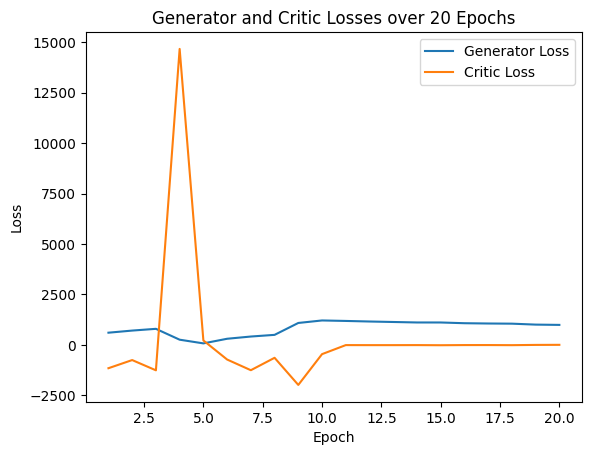

In [ ]:

import matplotlib.pyplot as plt
epochs = list(range(1, 21))

plt.plot(epochs, generator_losses, label='Generator Loss')
plt.plot(epochs, critic_losses, label='Critic Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Critic Losses over 20 Epochs')
plt.legend()
plt.show()


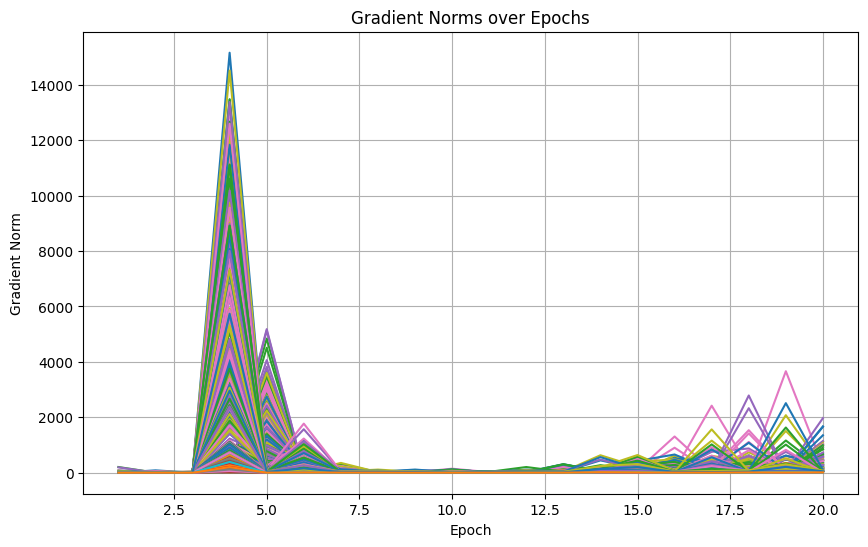

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
for i in range(len(gradient_norms_generator[0])):
    norms = [gradient_norms_generator[j][i] for j in range(len(gradient_norms_generator))]
    plt.plot(epochs, norms, label=f'Parameter {i+1}')

plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms over Epochs')
plt.grid(True)
plt.show()




In [ ]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Function to generate and display images
def generate_images(generator, num_images=24, noise_dim=100, grid_size=(8, 8)):
    # Create random noise for image generation
    noise = torch.randn(num_images, noise_dim).to(generator.model[0].weight.device)

    # Generate images from the noise
    with torch.no_grad():  # No gradients needed during inference
        generated_images = generator(noise)

    # Create a grid of images for visualization
    image_grid = vutils.make_grid(generated_images, nrow=grid_size[0], padding=2, normalize=True)
    image_grid = image_grid.cpu()

    # Display the image grid
    plt.imshow(image_grid.permute(1, 2, 0))  # Convert to HxWxC format
    plt.axis('off')  # Hide axes
    plt.show()  # Display the generated images


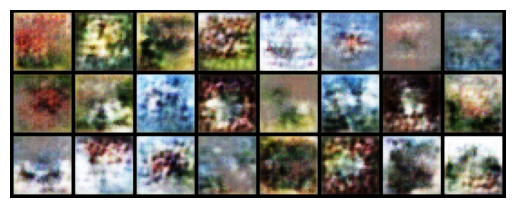

In [ ]:
generate_images(NetG)